<a href="https://colab.research.google.com/github/TomBeagley/MEng-FYP/blob/main/3D_CNN_Iteration_2_(small_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

Import all training and validation data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Create Training data set (images and labels) (all pre-processed in "pre-processing" notebook)

In [ ]:
#file_path = r"C:\Users\tombe\OneDrive - University of Bath\Documents\YEAR 4\FYP\Semester 2\Data\labelled data\labelsTr"
#os.chdir(file_path)
os.chdir("/content/gdrive/My Drive/FYP Data/labelled data/labelsTr")

all_files = os.listdir()
#print(all_files)
#print()

# get all nifti files (images)
nii_files = filter(lambda x: x[-4:] == '.nii', all_files)
nii_files = list(nii_files)
nii_files = sorted(nii_files)
print(nii_files)
print()

# get all csv files (labels)
csv_files = filter(lambda x: x[-4:] == '.csv', all_files)
csv_files = list(csv_files)
csv_files = sorted(csv_files)
print(csv_files)

train_images = list()
train_labels = list()


# read-in each image and its data
for item in nii_files:
    file_name = item
    image = nib.load(file_name)
    image_data = image.get_fdata()
    train_images.append(image_data)

# read-in each data frame of labels
for item in csv_files:
    file_name = item
    df = pd.read_csv(file_name)
    train_labels.append(df)

['S02.nii', 'S03.nii', 'S04.nii', 'S08.nii', 'S09.nii', 'S10.nii', 'S11.nii', 'S14.nii', 'S15.nii', 'S16.nii', 'S18.nii', 'S19.nii', 'S26.nii', 'S27.nii', 'S28.nii', 'S30.nii', 'S31.nii', 'S33.nii', 'S35.nii', 'S36.nii', 'S37.nii', 'S38.nii', 'S40.nii', 'S42.nii', 'S43.nii', 'S45.nii', 'S46.nii']

['S02_labels.csv', 'S03_labels.csv', 'S04_labels.csv', 'S08_labels.csv', 'S09_labels.csv', 'S10_labels.csv', 'S11_labels.csv', 'S14_labels.csv', 'S15_labels.csv', 'S16_labels.csv', 'S18_labels.csv', 'S19_labels.csv', 'S26_labels.csv', 'S27_labels.csv', 'S28_labels.csv', 'S30_labels.csv', 'S31_labels.csv', 'S33_labels.csv', 'S35_labels.csv', 'S36_labels.csv', 'S37_labels.csv', 'S38_labels.csv', 'S40_labels.csv', 'S42_labels.csv', 'S43_labels.csv', 'S45_labels.csv', 'S46_labels.csv']


Sample label from training dataset

In [ ]:
train_labels[0]

,x1,y1,z1,x2,y2,z2,x3,y3,z3
0,49,69,31,66,50,37,78,85,35


### Create Validation data set (images and labels) (all pre-processed in "pre-processing" notebook)

In [ ]:
#file_path = r"C:\Users\tombe\OneDrive - University of Bath\Documents\YEAR 4\FYP\Semester 2\Data\labelled data\labelsVa"
#os.chdir(file_path)
os.chdir("/content/gdrive/My Drive/FYP Data/labelled data/labelsVa")

all_files = os.listdir()
#print(all_files)
#print()

# get all nifti files (images)
nii_files = filter(lambda x: x[-4:] == '.nii', all_files)
nii_files = list(nii_files)
nii_files = sorted(nii_files)
print(nii_files)
print()

# get all csv files (labels)
csv_files = filter(lambda x: x[-4:] == '.csv', all_files)
csv_files = list(csv_files)
csv_files = sorted(csv_files)
print(csv_files)

validation_images = list()
validation_labels = list()


# read-in each image and its data
for item in nii_files:
    file_name = item
    image = nib.load(file_name)
    image_data = image.get_fdata()
    validation_images.append(image_data)

# read-in each data frame of labels
for item in csv_files:
    file_name = item
    df = pd.read_csv(file_name)
    validation_labels.append(df)

['S01.nii', 'S05.nii', 'S13.nii', 'S17.nii', 'S32.nii', 'S34.nii', 'S41.nii', 'S44.nii']

['S01_labels.csv', 'S05_labels.csv', 'S13_labels.csv', 'S17_labels.csv', 'S32_labels.csv', 'S34_labels.csv', 'S41_labels.csv', 'S44_labels.csv']


In [ ]:
validation_labels[0]

,x1,y1,z1,x2,y2,z2,x3,y3,z3
0,40,69,32,62,48,36,66,81,37


### View data before putting into model

In [ ]:
train_images = tf.stack(train_images)
train_labels = np.array(train_labels)
train_labels = tf.stack(train_labels)

validation_images = tf.stack(validation_images)
validation_labels = np.array(validation_labels)
validation_labels = tf.stack(validation_labels)

#test_images = tf.stack(test_images)
#test_labels = tf.stack(test_labels)

print(train_images.get_shape())
print(train_labels.get_shape())

print(validation_images.get_shape())
print(validation_labels.get_shape())

(27, 128, 128, 64)
(27, 1, 9)
(8, 128, 128, 64)
(8, 1, 9)


In [ ]:
os.chdir("/content/gdrive/My Drive/FYP Data")

In [ ]:
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

### 3D CNN Model

In [ ]:
# Define the input shape
input_shape = (27, 128, 128, 64, 1)

# Define the model architecture
model = keras.Sequential(
    [
        # First convolutional layer
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu", input_shape=input_shape[1:]),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),

        # Second convolutional layer
        layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu"),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),

        # Third convolutional layer
        layers.Conv3D(128, kernel_size=(3, 3, 3), activation="relu"),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),

        # Fourth convolutional layer
        layers.Conv3D(256, kernel_size=(3, 3, 3), activation="relu"),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),

        # Flatten the output of the convolutional layers
        layers.Flatten(),

        # First dense layer
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.3),

        # Second dense layer
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),

        # Output layer with three (changed to 9 as need 3 for each of the 3 endpoints) nodes for the x, y, and z coordinates of the pulmonary artery endpoints
        #layers.Dense(3, activation="softmax"),
        layers.Dense(9, activation="linear"), # doing a regression task right?
    ]
)

In [ ]:
# Compile the model with the appropriate loss function and optimizer
model.compile(
    loss="mean_squared_error", # again, regression task so use this instead of "binary_crossentropy" or "categorical_crossentropy"?
    optimizer=keras.optimizers.Adam(),
    metrics=["mean_absolute_error", "mean_squared_error", tf.keras.metrics.RootMeanSquaredError()],
)

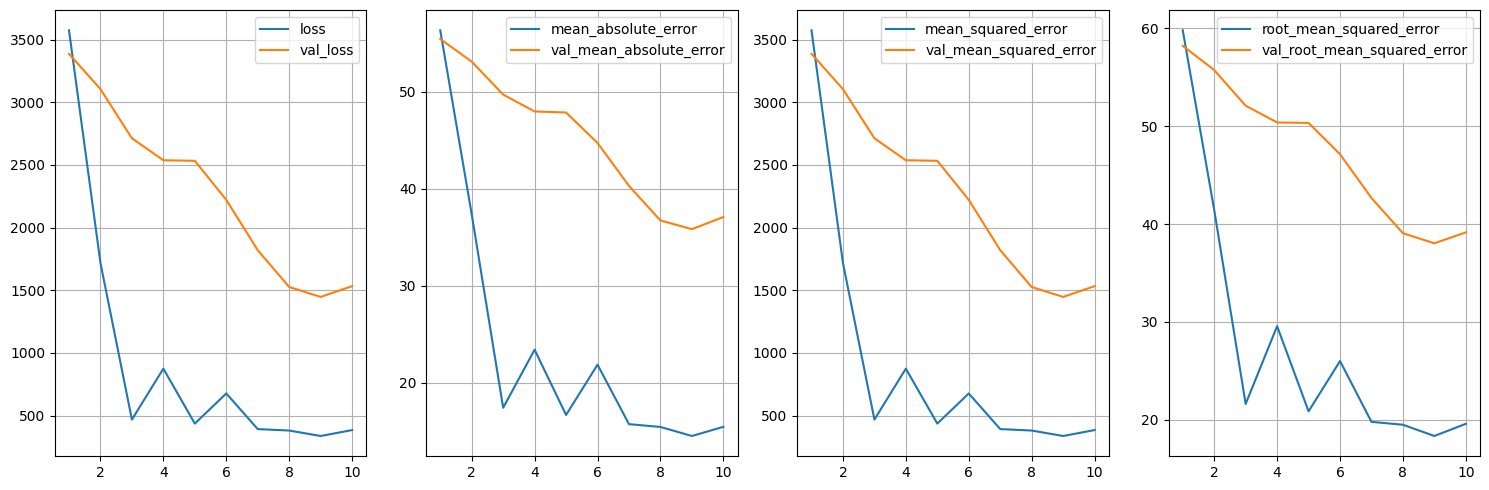

1/1 [==============================] - 162s 162s/step - loss: 384.1418 - mean_absolute_error: 15.4726 - mean_squared_error: 384.1418 - root_mean_squared_error: 19.5995 - val_loss: 1532.4056 - val_mean_absolute_error: 37.0955 - val_mean_squared_error: 1532.4056 - val_root_mean_squared_error: 39.1460


In [ ]:
callbacks_list = [PlotLearning()]
# Train the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(validation_images, validation_labels),
                    callbacks=callbacks_list)

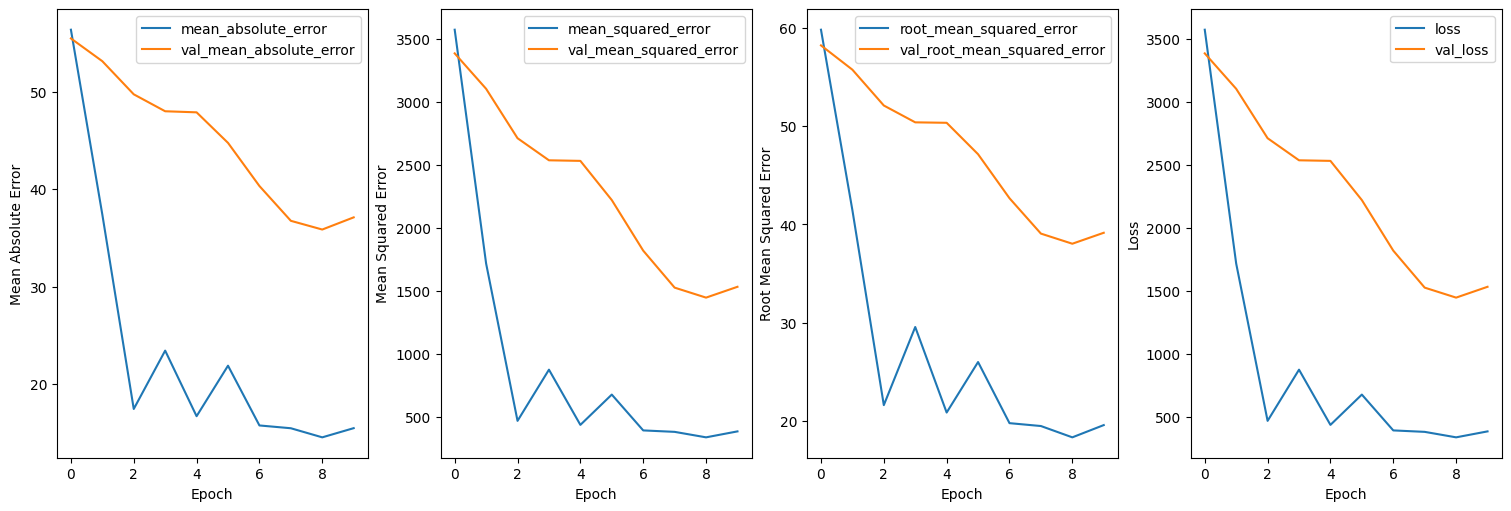

In [ ]:
# Evaluate model
fig, ax = plt.subplots(1, 4, figsize=(15, 5), constrained_layout=True)

ax[0].plot(history.history['mean_absolute_error'], label='mean_absolute_error')
ax[0].plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_ylim()
ax[0].legend(loc='upper right')

ax[1].plot(history.history['mean_squared_error'], label='mean_squared_error')
ax[1].plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Mean Squared Error')
ax[1].set_ylim()
ax[1].legend(loc='upper right')

ax[2].plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
ax[2].plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Root Mean Squared Error')
ax[2].set_ylim()
ax[2].legend(loc='upper right')

ax[3].plot(history.history['loss'], label='loss')
ax[3].plot(history.history['val_loss'], label = 'val_loss')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_ylim()
ax[3].legend(loc='upper right')

In [ ]:
#SAVE
model.save("/content/gdrive/My Drive/FYP Data/CNN MODEL v1")

# load model back:
# loaded_model = keras.models.load_model("/content/gdrive/My Drive/FYP Data/CNN MODEL v1")

In [ ]:
# TEST DATA SET

os.chdir("/content/gdrive/My Drive/FYP Data/FINAL DATA SET/labelsTe")

all_files = os.listdir()
#print(all_files)
#print()

# get all nifti files (images)
nii_files = filter(lambda x: x[-4:] == '.nii', all_files)
nii_files = list(nii_files)
nii_files = sorted(nii_files, key=lambda x: x.lower().replace("_", " "))
print(nii_files)
print()

# get all csv files (labels)
csv_files = filter(lambda x: x[-4:] == '.csv', all_files)
csv_files = list(csv_files)
csv_files = sorted(csv_files, key=lambda x: x.lower().replace("_", " "))
print(csv_files)

test_images = list()
test_labels = list()


# read-in each image and its data
for item in nii_files:
    file_name = item
    image = nib.load(file_name)
    image_data = image.get_fdata()
    test_images.append(image_data)

# read-in each data frame of labels
for item in csv_files:
    file_name = item
    df = pd.read_csv(file_name)
    test_labels.append(df)

test_images = tf.stack(test_images)
test_labels = np.array(test_labels)
test_labels = tf.stack(test_labels)

os.chdir("/content/gdrive/My Drive/FYP Data")

['S130.nii', 'S131.nii', 'S132.nii', 'S133.nii', 'S134.nii', 'S135.nii', 'S136.nii', 'S137.nii', 'S138.nii', 'S139.nii', 'S140.nii', 'S141.nii', 'S142.nii']

['S130_labels.csv', 'S131_labels.csv', 'S132_labels.csv', 'S133_labels.csv', 'S134_labels.csv', 'S135_labels.csv', 'S136_labels.csv', 'S137_labels.csv', 'S138_labels.csv', 'S139_labels.csv', 'S140_labels.csv', 'S141_labels.csv', 'S142_labels.csv']


In [ ]:
# EVALUATE
# Returns the loss value & metrics values for the model in test mode.
test_loss, test_mae, test_mse, test_rmse = model.evaluate(test_images,  test_labels, verbose=2)

1/1 - 8s - loss: 1522.3732 - mean_absolute_error: 37.1623 - mean_squared_error: 1522.3732 - root_mean_squared_error: 39.0176 - 8s/epoch - 8s/step


In [ ]:
#TEST

# Test data
unseen_images = test_images

# Use model to make predictions
predicted_endpoints = model.predict(unseen_images)

# show the inputs and predicted outputs
for i in range(len(unseen_images)):
 print("endpoint predicted coordinates=%s, endpoint ground truth coordinates=%s" % (predicted_endpoints[i], test_labels[i]))

1/1 [==============================] - 8s 8s/step
endpoint predicted coordinates=[17.989672 33.810474 11.542443 29.98566  18.993149 15.18282  32.37711
 32.764374 11.626216], endpoint ground truth coordinates=tf.Tensor([[52 77 26 70 50 34 74 78 39]], shape=(1, 9), dtype=int64)
endpoint predicted coordinates=[13.533322 25.778517  8.540874 23.451952 13.6967   11.23895  24.9253
 24.55713   7.950275], endpoint ground truth coordinates=tf.Tensor([[55 81 28 76 64 34 86 82 38]], shape=(1, 9), dtype=int64)
endpoint predicted coordinates=[11.48365   21.176924   8.307219  19.404146  11.0309515  9.176467
 21.407202  21.335974   7.664906 ], endpoint ground truth coordinates=tf.Tensor([[47 75 33 64 61 39 73 81 41]], shape=(1, 9), dtype=int64)
endpoint predicted coordinates=[14.044683  24.400717   8.931502  21.78118   14.259415  11.124206
 24.609272  24.876959   7.9581594], endpoint ground truth coordinates=tf.Tensor([[51 71 36 70 45 36 84 64 41]], shape=(1, 9), dtype=int64)
endpoint predicted coordi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 34.0 MB/s eta 0:00:00


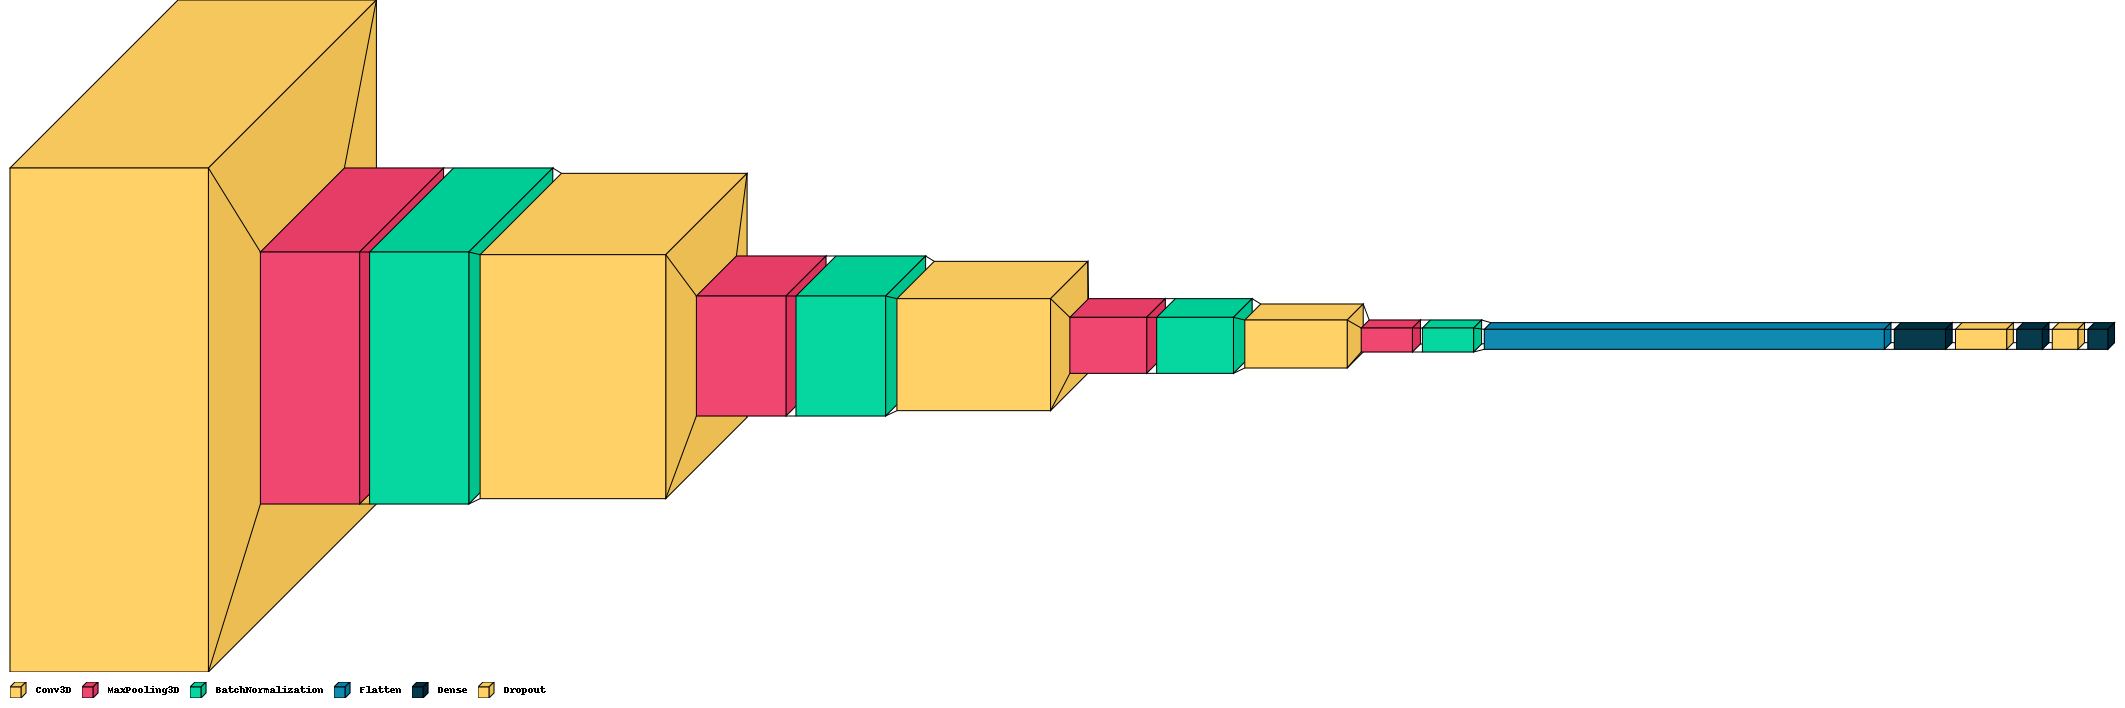

In [ ]:
!pip install visualkeras --q
import visualkeras

visualkeras.layered_view(model, legend=True).show()